In [1]:
from ipywidgets import IntProgress
import numpy as np
import seaborn as sns
import itertools 
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import transformers
import os

rc={'font.size': 8, 'axes.labelsize': 8, 'legend.fontsize': 10.0, 
    'axes.titlesize': 32, 'xtick.labelsize': 20, 'ytick.labelsize': 16}
plt.rcParams.update(**rc)
mpl.rcParams['axes.linewidth'] = .5 #set the value globally
import seaborn as sns; sns.set()
sns.set_style("whitegrid")
mpl.rcParams['axes.linewidth'] = 0.0 #set the value globally

import torch
from transformers import *
from transformers import BertConfig, BertForMaskedLM, BertTokenizer


import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [3]:
#@title Utilities

def get_adjmat(mat, input_tokens):
    n_layers, length, _ = mat.shape
    adj_mat = np.zeros(((n_layers+1)*length, (n_layers+1)*length))
    labels_to_index = {}
    for k in np.arange(length):
        labels_to_index[str(k)+"_"+input_tokens[k]] = k

    for i in np.arange(1,n_layers+1):
        for k_f in np.arange(length):
            index_from = (i)*length+k_f
            label = "L"+str(i)+"_"+str(k_f)
            labels_to_index[label] = index_from
            for k_t in np.arange(length):
                index_to = (i-1)*length+k_t
                adj_mat[index_from][index_to] = mat[i-1][k_f][k_t]
                
    return adj_mat, labels_to_index 


def draw_attention_graph(adjmat, labels_to_index, n_layers, length):
    A = adjmat
    G=nx.from_numpy_matrix(A, create_using=nx.DiGraph())
    for i in np.arange(A.shape[0]):
        for j in np.arange(A.shape[1]):
            nx.set_edge_attributes(G, {(i,j): A[i,j]}, 'capacity')

    pos = {}
    label_pos = {}
    for i in np.arange(n_layers+1):
        for k_f in np.arange(length):
            pos[i*length+k_f] = ((i+0.5)*2, length - k_f)
            label_pos[i*length+k_f] = (i*2, length - k_f)

    index_to_labels = {}
    for key in labels_to_index:
        index_to_labels[labels_to_index[key]] = key.split("_")[-1]
        if labels_to_index[key] >= length:
            index_to_labels[labels_to_index[key]] = ''

    #plt.figure(1,figsize=(20,12))

    nx.draw_networkx_nodes(G,pos,node_color='green', node_size=50)
    nx.draw_networkx_labels(G,pos=label_pos, labels=index_to_labels, font_size=10)

    all_weights = []
    #4 a. Iterate through the graph nodes to gather all the weights
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness

    #4 b. Get unique weights
    unique_weights = list(set(all_weights))

    #4 c. Plot the edges - one by one!
    for weight in unique_weights:
        #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner
        
        w = weight #(weight - min(all_weights))/(max(all_weights) - min(all_weights))
        width = w
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, edge_color='darkblue')
    
    return G
    
def compute_flows(G, labels_to_index, input_nodes, length):
    print(type(G))
    print(type(labels_to_index))
    print(type(input_nodes))
    number_of_nodes = len(labels_to_index)
    flow_values=np.zeros((number_of_nodes,number_of_nodes))
    for key in labels_to_index:
        if key not in input_nodes:
            current_layer = int(labels_to_index[key] / length)
            pre_layer = current_layer - 1
            u = labels_to_index[key]
            for inp_node_key in input_nodes:
                v = labels_to_index[inp_node_key]
                flow_value = nx.maximum_flow_value(G,u,v, flow_func=nx.algorithms.flow.edmonds_karp)
                flow_values[u][pre_layer*length+v ] = flow_value
            flow_values[u] /= flow_values[u].sum()
            
    return flow_values

def compute_node_flow(G, labels_to_index, input_nodes, output_nodes,length):
    number_of_nodes = len(labels_to_index)
    flow_values=np.zeros((number_of_nodes,number_of_nodes))
    for key in output_nodes:
        if key not in input_nodes:
            current_layer = int(labels_to_index[key] / length)
            pre_layer = current_layer - 1
            u = labels_to_index[key]
            for inp_node_key in input_nodes:
                v = labels_to_index[inp_node_key]
                flow_value = nx.maximum_flow_value(G,u,v, flow_func=nx.algorithms.flow.edmonds_karp)
                flow_values[u][pre_layer*length+v ] = flow_value
            flow_values[u] /= flow_values[u].sum()
            
    return flow_values

def compute_joint_attention(att_mat, add_residual=True):
    if add_residual:
        residual_att = np.eye(att_mat.shape[1])[None,...]
        aug_att_mat = att_mat + residual_att
        aug_att_mat = aug_att_mat / aug_att_mat.sum(axis=-1)[...,None]
    else:
       aug_att_mat =  att_mat
    
    joint_attentions = np.zeros(aug_att_mat.shape)

    layers = joint_attentions.shape[0]
    joint_attentions[0] = aug_att_mat[0]
    for i in np.arange(1,layers):
        joint_attentions[i] = aug_att_mat[i].dot(joint_attentions[i-1])
        
    return joint_attentions

def plot_attention_heatmap(att, s_position, t_positions, sentence):

  print(att[:,s_position, t_positions].shape)
  for idx, values in enumerate(att[:,s_position, t_positions]):
      print(f"idx:{idx} values:{values}")
  cls_att = np.flip(att[:,s_position, t_positions], axis=0)
  xticklb = input_tokens= list(itertools.compress(['<cls>']+sentence.split(), [i in t_positions for i in np.arange(len(sentence)+1)]))
  yticklb = [str(i) if i%2 ==0 else '' for i in np.arange(att.shape[0],0, -1)]
  ax = sns.heatmap(cls_att, xticklabels=xticklb, yticklabels=yticklb, cmap="YlOrRd")
  return ax

def convert_adjmat_tomats(adjmat, n_layers, l):
   mats = np.zeros((n_layers,l,l))
   
   for i in np.arange(n_layers):
       mats[i] = adjmat[(i+1)*l:(i+2)*l,i*l:(i+1)*l]
       
   return mats

def print_top_7(joint_weight_matrix, input_tokens, target_word_idx):
    joint_weight_matrix = torch.tensor(joint_weight_matrix)[:,target_word_idx,:]
    print(joint_weight_matrix.shape)
    top_7_values, top_7_indices = torch.topk(joint_weight_matrix, k=7)
    for cur_idx, (top_7_index, top_7_value) in enumerate(zip(top_7_indices, top_7_values)):
        print(f"idx:{cur_idx} word:{input_tokens[target_word_idx]}")
        for top_idx, (item_idx, weight_value) in enumerate(zip(top_7_index, top_7_value)):
            print(item_idx)
            print(f"\ttop{top_idx+1}_idx:{item_idx} (word:{input_tokens[item_idx]}) {weight_value}")


In [4]:
# tokenizer = transformers.BertTokenizer.from_pretrained("bert-large-uncased-whole-word-masking")
# model = transformers.BertModel.from_pretrained("bert-large-uncased-whole-word-masking")
tokenizer = transformers.BertTokenizer.from_pretrained("bert-large-uncased")
model = transformers.BertForMaskedLM.from_pretrained("bert-large-uncased")

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
sentence = "The author talked to Sara about " + tokenizer.mask_token + " book"
tokens = ['[cls]']+tokenizer.tokenize(sentence)+['[sep]']
print(len(tokens), tokens)
tf_input_ids = tokenizer.encode(sentence)
print(tokenizer.decode(tf_input_ids))
input_ids = torch.tensor([tf_input_ids])
all_attentions = model(input_ids, output_attentions=True).attentions

_attentions = [att.detach().numpy() for att in all_attentions]
attentions_mat = np.asarray(_attentions)[:,0]
print(attentions_mat.shape)

10 ['[cls]', 'the', 'author', 'talked', 'to', 'sara', 'about', '[MASK]', 'book', '[sep]']
[CLS] the author talked to sara about [MASK] book [SEP]
(24, 16, 10, 10)


In [6]:
MASK_IDX = 7 # 7 is the masking idx for "the author talked to Sara about [mask] book" 
INDICES_TO_INSPECT = (2,5) # (2,5) is the indices of the entities to inspect (i.e. author and Sara)
output = model(input_ids)[0]
predicted_target = torch.nn.Softmax()(output[0, MASK_IDX])

print(np.argmax(output.detach().numpy()[0], axis=-1))
print(tokenizer.decode(np.argmax(output.detach().numpy()[0], axis=-1)))
print(tf_input_ids[MASK_IDX], tokenizer.decode([tf_input_ids[MASK_IDX]]))
print(tf_input_ids[INDICES_TO_INSPECT[0]], tokenizer.decode([tf_input_ids[INDICES_TO_INSPECT[0]]]), predicted_target[tf_input_ids[INDICES_TO_INSPECT[0]]])
print(tf_input_ids[INDICES_TO_INSPECT[1]], tokenizer.decode([tf_input_ids[INDICES_TO_INSPECT[1]]]), predicted_target[tf_input_ids[INDICES_TO_INSPECT[1]]])
his_id = tokenizer.encode(['his'])[1]
her_id = tokenizer.encode(['her'])[1]

print(his_id, her_id)
print("his prob:", predicted_target[his_id], "her prob:", predicted_target[her_id], "her?", predicted_target[her_id] > predicted_target[his_id])

[1012 1996 3166 5720 2000 7354 2055 1996 2338 1012]
. the author talked to sara about the book.
103 [MASK]
3166 author tensor(4.4339e-08, grad_fn=<SelectBackward>)
7354 sara tensor(1.5471e-08, grad_fn=<SelectBackward>)
2010 2014
his prob: tensor(0.3558, grad_fn=<SelectBackward>) her prob: tensor(0.1219, grad_fn=<SelectBackward>) her? tensor(False)


/home/hkkang/NL2QGM/venv_rat/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


In [7]:
 float(predicted_target[her_id].detach().numpy())

0.1219472885131836

his_prob:0.35583457350730896, her_prob:0.1219472885131836


/home/hkkang/NL2QGM/venv_rat/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


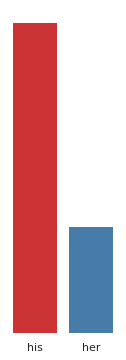

In [8]:
print(f"his_prob:{float(predicted_target[his_id].detach().numpy())}, her_prob:{predicted_target[her_id].detach().numpy()}")
fig = plt.figure(1,figsize=(2,6))
ax = sns.barplot(['his', 'her'], [ float(predicted_target[his_id].detach().numpy()),  float(predicted_target[her_id].detach().numpy())], linewidth=0, palette='Set1')
sns.despine(fig=fig, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
ax.set_yticks([])
plt.savefig('rat_bert_bar_{}.png'.format(2), format='png', transparent=True, dpi=360, bbox_inches='tight')

(24, 2)
idx:0 values:[0.02374035 0.03037107]
idx:1 values:[0.01394891 0.0113528 ]
idx:2 values:[0.02784163 0.0064163 ]
idx:3 values:[0.02315998 0.01325378]
idx:4 values:[0.02942407 0.01403769]
idx:5 values:[0.0322874  0.02189005]
idx:6 values:[0.03306001 0.02002503]
idx:7 values:[0.02683682 0.02362814]
idx:8 values:[0.0387819  0.02970235]
idx:9 values:[0.03566398 0.02445441]
idx:10 values:[0.03756614 0.04067699]
idx:11 values:[0.03179512 0.02988535]
idx:12 values:[0.03158432 0.0514011 ]
idx:13 values:[0.04868275 0.02323384]
idx:14 values:[0.06757756 0.02569154]
idx:15 values:[0.05580156 0.03095465]
idx:16 values:[0.04280914 0.03217532]
idx:17 values:[0.07676934 0.01716891]
idx:18 values:[0.06415658 0.03437693]
idx:19 values:[0.05867368 0.01375113]
idx:20 values:[0.03050911 0.01491417]
idx:21 values:[0.02616603 0.01132434]
idx:22 values:[0.0617085  0.02037937]
idx:23 values:[0.00746592 0.01463615]


<AxesSubplot:>

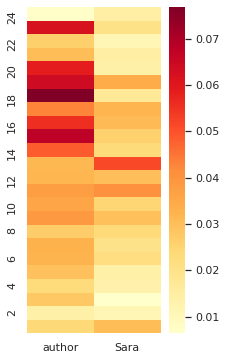

In [9]:
plt.figure(1,figsize=(3,6))
plot_attention_heatmap(attentions_mat.sum(axis=1)/attentions_mat.shape[1], MASK_IDX, t_positions=INDICES_TO_INSPECT, sentence=sentence)


In [10]:
# Show raw attention weights
#print_top_7(attentions_mat.sum(axis=1)/attentions_mat.shape[1], tokens, MASK_IDX)

In [11]:
#@title Get raw attention mat + residual coonections

res_att_mat = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]
res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]
 
res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokens)



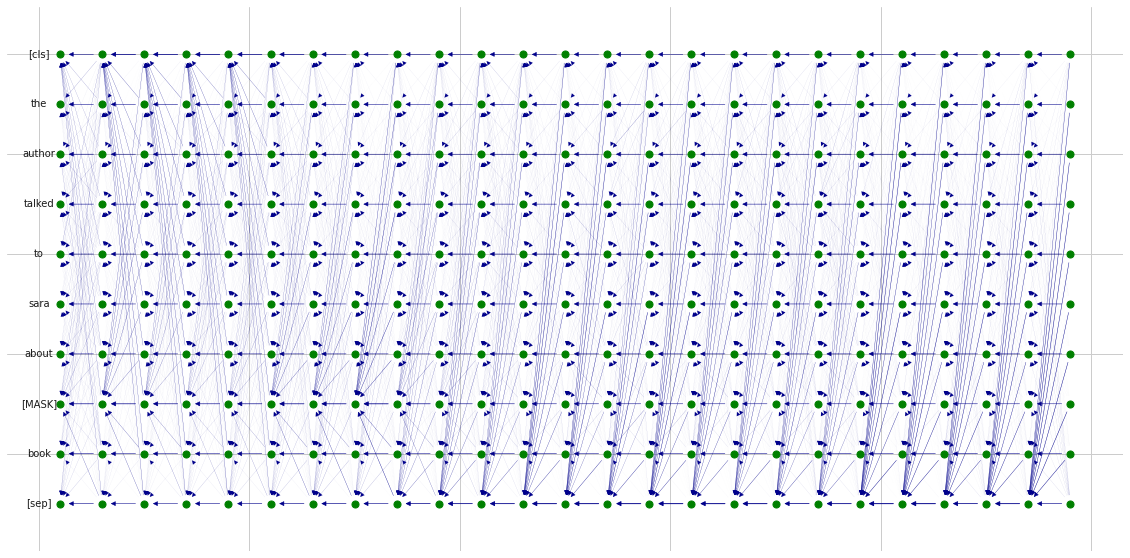

In [12]:
#@title plot the attention graph
plt.figure(figsize=(20,10))

# res_adj_mat and res_labels_to_index are the results of get_adjmat()
res_G = draw_attention_graph(res_adj_mat,res_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])

(24, 2)
idx:0 values:[0.01187017 0.01518553]
idx:1 values:[0.00697445 0.0056764 ]
idx:2 values:[0.01392081 0.00320815]
idx:3 values:[0.01157999 0.00662689]
idx:4 values:[0.01471203 0.00701885]
idx:5 values:[0.0161437  0.01094502]
idx:6 values:[0.01653    0.01001252]
idx:7 values:[0.01341841 0.01181407]
idx:8 values:[0.01939095 0.01485117]
idx:9 values:[0.01783199 0.0122272 ]
idx:10 values:[0.01878307 0.02033849]
idx:11 values:[0.01589756 0.01494268]
idx:12 values:[0.01579216 0.02570055]
idx:13 values:[0.02434138 0.01161692]
idx:14 values:[0.03378878 0.01284577]
idx:15 values:[0.02790078 0.01547732]
idx:16 values:[0.02140457 0.01608766]
idx:17 values:[0.03838467 0.00858446]
idx:18 values:[0.03207829 0.01718847]
idx:19 values:[0.02933684 0.00687556]
idx:20 values:[0.01525456 0.00745709]
idx:21 values:[0.01308301 0.00566217]
idx:22 values:[0.03085425 0.01018968]
idx:23 values:[0.00373296 0.00731807]


<AxesSubplot:>

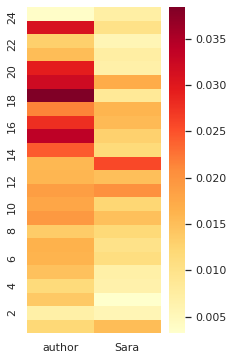

In [13]:
#@title Plot contrastive heatmap

plt.figure(1,figsize=(3,6))
plot_attention_heatmap(res_att_mat, MASK_IDX, t_positions=INDICES_TO_INSPECT, sentence=sentence)


In [14]:
#@title Compute attention rollout

joint_attentions = compute_joint_attention(res_att_mat, add_residual=False)
joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=tokens)


(24, 2)
idx:0 values:[0.01187017 0.01518553]
idx:1 values:[0.01971315 0.02151573]
idx:2 values:[0.0262032  0.02411761]
idx:3 values:[0.03024549 0.02606011]
idx:4 values:[0.03215082 0.02713197]
idx:5 values:[0.03368451 0.02789597]
idx:6 values:[0.03447033 0.0282997 ]
idx:7 values:[0.03483528 0.0285141 ]
idx:8 values:[0.03511528 0.02866835]
idx:9 values:[0.03529797 0.02875856]
idx:10 values:[0.03538846 0.02881932]
idx:11 values:[0.035407   0.02883581]
idx:12 values:[0.03540528 0.02884399]
idx:13 values:[0.0354008  0.02884126]
idx:14 values:[0.03538222 0.02883268]
idx:15 values:[0.03536853 0.02882752]
idx:16 values:[0.03536115 0.02882459]
idx:17 values:[0.03535525 0.02882201]
idx:18 values:[0.03535172 0.02882061]
idx:19 values:[0.03534864 0.02881937]
idx:20 values:[0.03534635 0.02881848]
idx:21 values:[0.0353451 0.028818 ]
idx:22 values:[0.03534461 0.02881781]
idx:23 values:[0.03534432 0.0288177 ]


<AxesSubplot:>

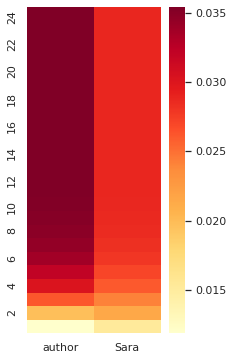

In [15]:
#@title Plot contrastive heatmap

plt.figure(1,figsize=(3,6))
plot_attention_heatmap(joint_attentions, MASK_IDX, t_positions=INDICES_TO_INSPECT, sentence=sentence)


In [22]:
print(attentions_mat.shape[-1])
print(res_labels_to_index)

10
{'0_[cls]': 0, '1_the': 1, '2_author': 2, '3_talked': 3, '4_to': 4, '5_sara': 5, '6_about': 6, '7_[MASK]': 7, '8_book': 8, '9_[sep]': 9, 'L1_0': 10, 'L1_1': 11, 'L1_2': 12, 'L1_3': 13, 'L1_4': 14, 'L1_5': 15, 'L1_6': 16, 'L1_7': 17, 'L1_8': 18, 'L1_9': 19, 'L2_0': 20, 'L2_1': 21, 'L2_2': 22, 'L2_3': 23, 'L2_4': 24, 'L2_5': 25, 'L2_6': 26, 'L2_7': 27, 'L2_8': 28, 'L2_9': 29, 'L3_0': 30, 'L3_1': 31, 'L3_2': 32, 'L3_3': 33, 'L3_4': 34, 'L3_5': 35, 'L3_6': 36, 'L3_7': 37, 'L3_8': 38, 'L3_9': 39, 'L4_0': 40, 'L4_1': 41, 'L4_2': 42, 'L4_3': 43, 'L4_4': 44, 'L4_5': 45, 'L4_6': 46, 'L4_7': 47, 'L4_8': 48, 'L4_9': 49, 'L5_0': 50, 'L5_1': 51, 'L5_2': 52, 'L5_3': 53, 'L5_4': 54, 'L5_5': 55, 'L5_6': 56, 'L5_7': 57, 'L5_8': 58, 'L5_9': 59, 'L6_0': 60, 'L6_1': 61, 'L6_2': 62, 'L6_3': 63, 'L6_4': 64, 'L6_5': 65, 'L6_6': 66, 'L6_7': 67, 'L6_8': 68, 'L6_9': 69, 'L7_0': 70, 'L7_1': 71, 'L7_2': 72, 'L7_3': 73, 'L7_4': 74, 'L7_5': 75, 'L7_6': 76, 'L7_7': 77, 'L7_8': 78, 'L7_9': 79, 'L8_0': 80, 'L8_1': 

In [16]:
#@title Compute attention flow (this will take quite some time to compute).

output_nodes = []
input_nodes = []
for key in res_labels_to_index:
    if 'L24' in key:
        output_nodes.append(key)
    if res_labels_to_index[key] < attentions_mat.shape[-1]:
        input_nodes.append(key)

# res_G is the result graph of draw_attention_graph()
# input_nodes should contain keys correponding to the input tokens
# length should be the length of the input sequence
flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])


<class 'networkx.classes.digraph.DiGraph'>
<class 'dict'>
<class 'list'>


In [17]:
flow_att_mat = convert_adjmat_tomats(flow_values, n_layers=attentions_mat.shape[0], l=attentions_mat.shape[-1])
print(torch.tensor(flow_values).shape)
print(torch.tensor(flow_att_mat).shape)

torch.Size([250, 250])
torch.Size([24, 10, 10])


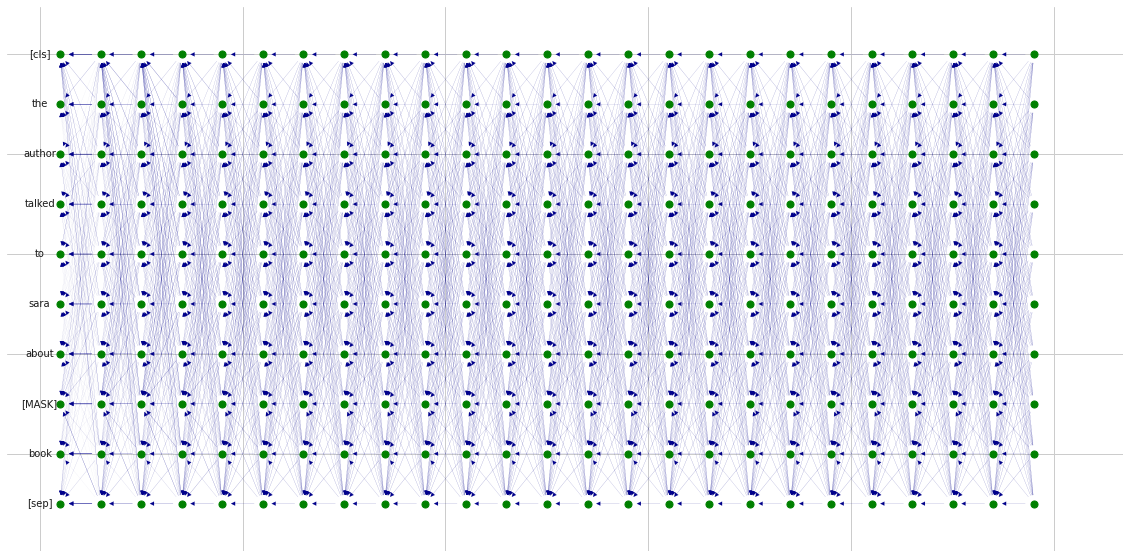

In [18]:
#@title Draw attention flow graph

plt.figure(figsize=(20,10))
flow_G = draw_attention_graph(flow_values,res_labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])

(24, 2)
idx:0 values:[0.01187017 0.01518553]
idx:1 values:[0.04210706 0.04718439]
idx:2 values:[0.0620468  0.06497105]
idx:3 values:[0.08550272 0.05571225]
idx:4 values:[0.09826307 0.05651417]
idx:5 values:[0.10967133 0.06445427]
idx:6 values:[0.10763556 0.07960638]
idx:7 values:[0.10676364 0.08706214]
idx:8 values:[0.10676364 0.08706214]
idx:9 values:[0.10676364 0.08706214]
idx:10 values:[0.10676364 0.08706214]
idx:11 values:[0.10676364 0.08706214]
idx:12 values:[0.10676364 0.08706214]
idx:13 values:[0.10676364 0.08706214]
idx:14 values:[0.10676364 0.08706214]
idx:15 values:[0.10676364 0.08706214]
idx:16 values:[0.10676364 0.08706214]
idx:17 values:[0.10676364 0.08706214]
idx:18 values:[0.10676364 0.08706214]
idx:19 values:[0.10676364 0.08706214]
idx:20 values:[0.10676364 0.08706214]
idx:21 values:[0.10676364 0.08706214]
idx:22 values:[0.10676364 0.08706214]
idx:23 values:[0.10676364 0.08706214]


<AxesSubplot:>

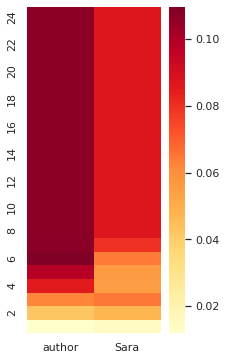

In [19]:
#@title Plot contrastive heatmap
flow_att_mat = convert_adjmat_tomats(flow_values, n_layers=attentions_mat.shape[0], l=attentions_mat.shape[-1])

plt.figure(1,figsize=(3,6))
plot_attention_heatmap(flow_att_mat, MASK_IDX, t_positions=INDICES_TO_INSPECT, sentence=sentence)